In [3]:
import torch
import torch.nn as nn
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from pennylane.templates import StronglyEntanglingLayers

# ----------------------------------------------------------
# Hyperparameter Settings
# ----------------------------------------------------------
num_qubits = 2                # Number of qubits used in the quantum circuit
trainable_block_layers = 2                # Number of trainable layers (variational layers)
learning_rate = 0.3          # Learning rate for the optimizer
num_iterations = 50          # Number of training iterations
n_points = 100                # Number of training points sampled in the interval [0, 2π]
np.random.seed(42)
scaling = 1
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device for acceleration.")
else:
    device = torch.device("cpu")
    print("Using CPU device.")
dev = qml.device("default.qubit", wires=num_qubits)

Using MPS device for acceleration.


Training started...
Iteration 50/50, Total Loss: 0.006897, PDE Loss: 0.006812, Boundary Loss: 0.000085
Training finished.


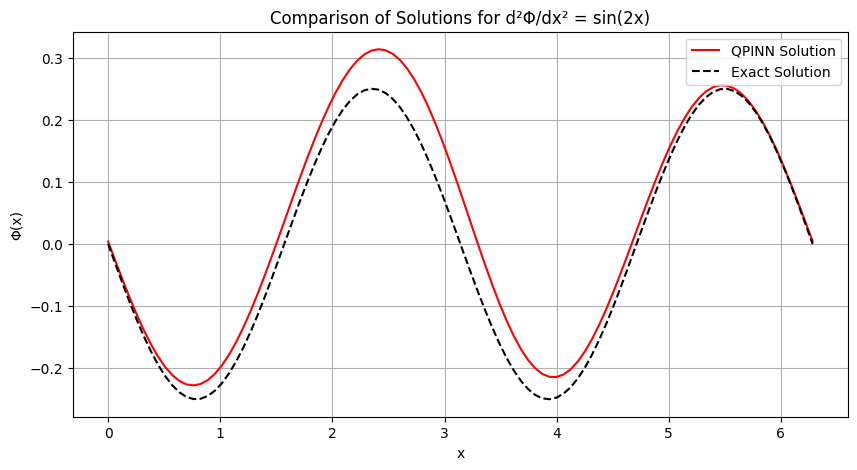

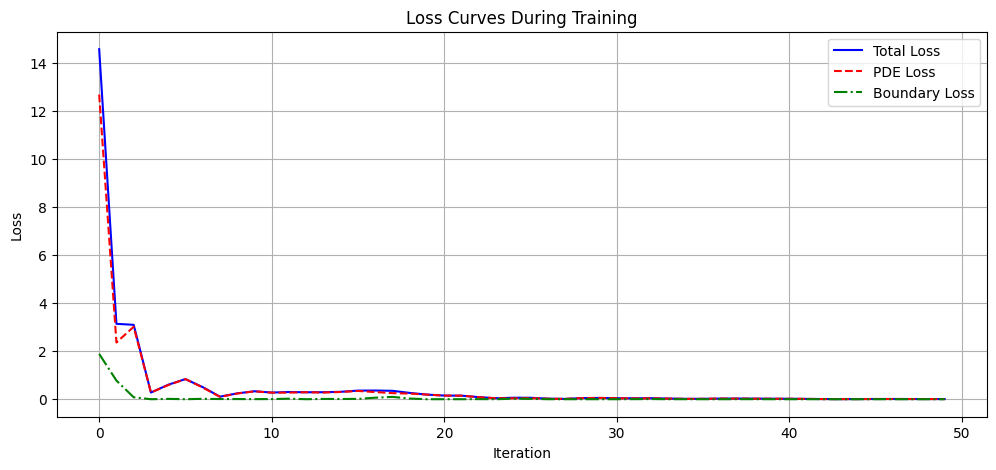

In [1]:
# ----------------------------------------------------------
# Define the quantum circuit
# ----------------------------------------------------------
def S(x):
    """Data encoding circuit block."""
    for w in range(num_qubits):
        qml.RX(scaling*x, wires=w)

def W(theta):
    """Trainable circuit block."""
    StronglyEntanglingLayers(theta, wires=range(num_qubits))


@qml.qnode(dev, interface="torch", diff_method="backprop")
def parallel_quantum_model(weights, x=None):

    W(weights[0])

    for i in range(1,trainable_block_layers+1):
        S(scaling*x)
        W(weights[i])

    return qml.expval(qml.PauliZ(wires=0))

# ----------------------------------------------------------
# Define the QPINN network structure, encapsulating the QNode
# ----------------------------------------------------------
class QPINN(nn.Module):
    def __init__(self):
        super(QPINN, self).__init__()
        # Initialize trainable parameters
        self.weights = nn.Parameter(0.1 * torch.randn((1+trainable_block_layers, trainable_block_layers, num_qubits, 3), dtype=torch.float32, requires_grad=True))

    def forward(self, x):
        # Assume x is a one-dimensional tensor; call the QNode for each sample
        outputs = []
        for xi in x:
            outputs.append(parallel_quantum_model(self.weights, xi))
        return torch.stack(outputs)

# ----------------------------------------------------------
# Create an instance of the QPINN model
# ----------------------------------------------------------
model = QPINN()

# ----------------------------------------------------------
# Construct the physics-informed loss function (PDE residual and boundary conditions)
# ----------------------------------------------------------
def compute_pde_residual(phi_pred, x):
    """
    Compute the PDE residual:
        d²Φ/dx² - sin(2x) = 0
    Use PyTorch’s automatic differentiation to compute the first and second derivatives.
    """
    # Compute the first derivative dΦ/dx
    dphi_dx = torch.autograd.grad(
        phi_pred, x,
        grad_outputs=torch.ones_like(phi_pred),
        create_graph=True
    )[0]
    # Compute the second derivative d²Φ/dx²
    d2phi_dx2 = torch.autograd.grad(
        dphi_dx, x,
        grad_outputs=torch.ones_like(dphi_dx),
        create_graph=True
    )[0]

    # Define the PDE residual as d²Φ/dx² - sin(2x)
    residual = d2phi_dx2 - torch.sin(2 * x)
    return residual

def loss_function(x):
    """
    Compute the total loss:
      - PDE loss: Mean squared error of the residual
      - Boundary condition loss: Apply a penalty to ensure Φ(0)=0 and Φ(2π)=0
    """
    x.requires_grad_(True)
    phi_pred = model(x)
    residual = compute_pde_residual(phi_pred, x)
    pde_loss = torch.mean(residual**2)

    # Boundary conditions: Φ(0) = 0 and Φ(2π) = 0
    bc0 = model(torch.tensor([0.0], dtype=x.dtype))
    bc1 = model(torch.tensor([2 * np.pi], dtype=x.dtype))
    bc_loss = bc0.pow(2).mean() + bc1.pow(2).mean()

    total_loss = pde_loss + bc_loss  # Adjust the weight for boundary condition loss as needed
    return total_loss, pde_loss, bc_loss

# ----------------------------------------------------------
# Model training
# ----------------------------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
x_train = torch.linspace(0, 2 * np.pi, n_points, dtype=torch.float32)

total_loss_list = []
pde_loss_list = []
bc_loss_list = []

print("Training started...")
for i in range(num_iterations):
    optimizer.zero_grad()
    total_loss_value, pde_loss_value, bc_loss_value = loss_function(x_train)
    total_loss_value.backward()
    optimizer.step()

    total_loss_list.append(total_loss_value.item())
    pde_loss_list.append(pde_loss_value.item())
    bc_loss_list.append(bc_loss_value.item())

    if (i + 1) % 50 == 0:
        print(f"Iteration {i+1}/{num_iterations}, Total Loss: {total_loss_value.item():.6f}, "
              f"PDE Loss: {pde_loss_value.item():.6f}, Boundary Loss: {bc_loss_value.item():.6f}")

print("Training finished.")

# ----------------------------------------------------------
# Model evaluation and comparison of solutions
# ----------------------------------------------------------
# Generate grid data for evaluation
x_eval = torch.linspace(0, 2 * np.pi, 100, dtype=torch.float32)
with torch.no_grad():
    phi_pred_eval = model(x_eval)

def exact_solution(x):
    """
    Exact solution:
      Φ(x) = -1/4 * sin(2x)
    """
    return -0.25 * torch.sin(2 * x)

phi_exact_eval = exact_solution(x_eval)

# ----------------------------------------------------------
# Plot the comparison between QPINN solution and the exact solution
# ----------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(x_eval.cpu().numpy(), phi_pred_eval.cpu().numpy(), 'r-', label='QPINN Solution')
plt.plot(x_eval.cpu().numpy(), phi_exact_eval.cpu().numpy(), 'k--', label='Exact Solution')
plt.title("Comparison of Solutions for d²Φ/dx² = sin(2x)")
plt.xlabel("x")
plt.ylabel("Φ(x)")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------------------
# Plot the loss curves during training
# ----------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(total_loss_list, 'b-', label='Total Loss')
plt.plot(pde_loss_list, 'r--', label='PDE Loss')
plt.plot(bc_loss_list, 'g-.', label='Boundary Loss')
plt.title("Loss Curves During Training")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Using MPS device for acceleration (for classical parts).
Training started...
Iteration 10/100, Total Loss: 3.039897, PDE Loss: 2.806998, Boundary Loss: 0.232899
Iteration 20/100, Total Loss: 0.644723, PDE Loss: 0.636985, Boundary Loss: 0.007738
Iteration 30/100, Total Loss: 0.105252, PDE Loss: 0.098194, Boundary Loss: 0.007058
Iteration 40/100, Total Loss: 0.058196, PDE Loss: 0.008374, Boundary Loss: 0.049822
Iteration 50/100, Total Loss: 0.026048, PDE Loss: 0.015651, Boundary Loss: 0.010397
Iteration 60/100, Total Loss: 0.007348, PDE Loss: 0.005420, Boundary Loss: 0.001929
Iteration 70/100, Total Loss: 0.003140, PDE Loss: 0.002672, Boundary Loss: 0.000468
Iteration 80/100, Total Loss: 0.001855, PDE Loss: 0.001471, Boundary Loss: 0.000384
Iteration 90/100, Total Loss: 0.000986, PDE Loss: 0.000868, Boundary Loss: 0.000118
Iteration 100/100, Total Loss: 0.000527, PDE Loss: 0.000482, Boundary Loss: 0.000045
Training finished.


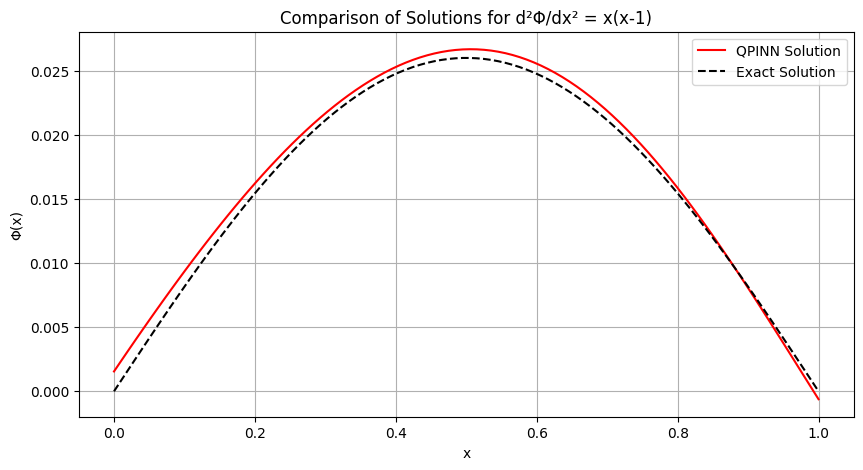

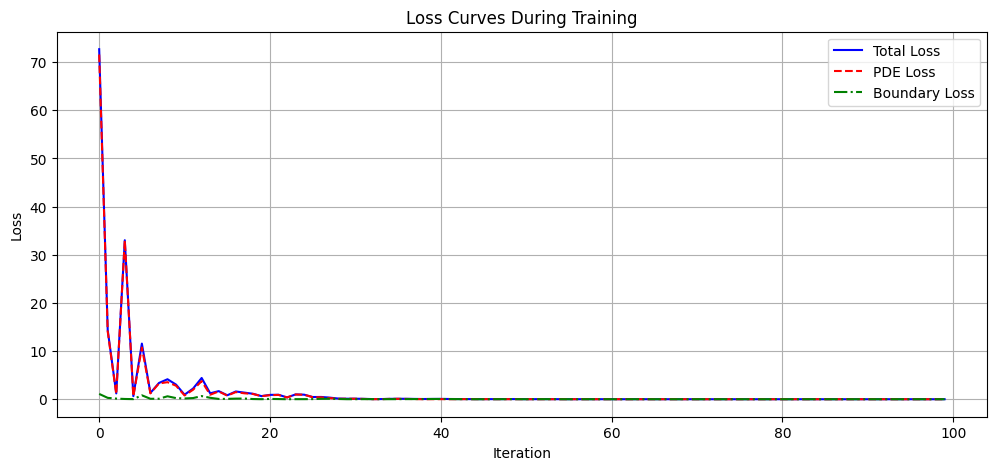

In [10]:
import torch
import torch.nn as nn
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from pennylane.templates import StronglyEntanglingLayers

# Hyperparameters remain as before
num_qubits = 2
trainable_block_layers = 4
learning_rate = 0.3
num_iterations = 100
n_points = 100
np.random.seed(42)
scaling = 1

# Choose main device for PyTorch; use MPS if available otherwise CPU.
# Note: We will use CPU for PennyLane quantum parts
if torch.backends.mps.is_available():
    main_device = torch.device("mps")
    print("Using MPS device for acceleration (for classical parts).")
else:
    main_device = torch.device("cpu")
    print("Using CPU device.")

# Create a PennyLane device on CPU (to avoid complex number issues on MPS)
dev = qml.device("default.qubit", wires=num_qubits, shots=None)  # default.qubit runs on CPU

# Define your quantum circuit blocks and QNode as before.
def S(x):
    for w in range(num_qubits):
        qml.RX(scaling * x, wires=w)

def W(theta):
    StronglyEntanglingLayers(theta, wires=range(num_qubits))

@qml.qnode(dev, interface="torch", diff_method="backprop")
def parallel_quantum_model(weights, x=None):
    W(weights[0])
    for i in range(1, trainable_block_layers + 1):
        S(scaling * x)
        W(weights[i])
    return qml.expval(qml.PauliZ(wires=0))

# class QPINN(nn.Module):
#     def __init__(self):
#         super(QPINN, self).__init__()
#         # Use same parameter shape
#         self.weights = nn.Parameter(
#             0.1 * torch.randn((1 + trainable_block_layers, trainable_block_layers, num_qubits, 3), dtype=torch.float32)
#         )
#     def forward(self, x):
#         # Evaluate quantum circuit for each sample
#         outputs = [parallel_quantum_model(self.weights, xi) for xi in x]
#         return torch.stack(outputs)

class QPINN(nn.Module):
    def __init__(self):
        super(QPINN, self).__init__()
        self.weights = nn.Parameter(
            0.1 * torch.randn((1 + trainable_block_layers, trainable_block_layers, num_qubits, 3),
                              dtype=torch.float32)
        )

    def forward(self, x):
        # Cast weights to CPU before passing into the QNode.
        weights_cpu = self.weights.to("cpu")
        outputs = []
        for xi in x:
            # Convert each input sample to CPU.
            xi_cpu = xi.to("cpu")
            # Evaluate the quantum circuit.
            output = parallel_quantum_model(weights_cpu, xi_cpu)
            # Force output to float32 (since MPS doesn't support float64)
            output = output.to(torch.float32)
            # Move the output back to the device of x (MPS) if needed.
            outputs.append(output.to(device=x.device))
        return torch.stack(outputs)



# Create model on the main device (MPS if possible) for classical training,
# while the quantum circuit runs on CPU.
model = QPINN().to(main_device)

# Loss function and training: use your previously defined functions, but ensure that the training tensor stays on main_device.
def compute_pde_residual(phi_pred, x):
    dphi_dx = torch.autograd.grad(
        phi_pred, x, grad_outputs=torch.ones_like(phi_pred), create_graph=True
    )[0]
    d2phi_dx2 = torch.autograd.grad(
        dphi_dx, x, grad_outputs=torch.ones_like(dphi_dx), create_graph=True
    )[0]
    residual = d2phi_dx2 - (x * (x - 1))
    return residual

def loss_function(x):
    x.requires_grad_(True)
    phi_pred = model(x)
    residual = compute_pde_residual(phi_pred, x)
    pde_loss = torch.mean(residual**2)
    # Use boundary conditions at x=0 and x=1
    bc0 = model(torch.tensor([0.0], dtype=x.dtype, device=main_device))
    bc1 = model(torch.tensor([1.0], dtype=x.dtype, device=main_device))
    bc_loss = bc0.pow(2).mean() + bc1.pow(2).mean()
    total_loss = pde_loss + bc_loss
    return total_loss, pde_loss, bc_loss

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
x_train = torch.linspace(0, 1, n_points, dtype=torch.float32, device=main_device)

total_loss_list = []
pde_loss_list = []
bc_loss_list = []

print("Training started...")
for i in range(num_iterations):
    optimizer.zero_grad()
    total_loss_value, pde_loss_value, bc_loss_value = loss_function(x_train)
    total_loss_value.backward()
    optimizer.step()

    total_loss_list.append(total_loss_value.item())
    pde_loss_list.append(pde_loss_value.item())
    bc_loss_list.append(bc_loss_value.item())

    if (i + 1) % 10 == 0:
        print(f"Iteration {i+1}/{num_iterations}, Total Loss: {total_loss_value.item():.6f}, "
              f"PDE Loss: {pde_loss_value.item():.6f}, Boundary Loss: {bc_loss_value.item():.6f}")

print("Training finished.")

# Evaluation and plotting as before
x_eval = torch.linspace(0, 1, 100, dtype=torch.float32, device=main_device)
with torch.no_grad():
    phi_pred_eval = model(x_eval)

def exact_solution(x):
    return (x**4)/12 - (x**3)/6 + x/12

phi_exact_eval = exact_solution(x_eval)

x_eval_np = x_eval.cpu().numpy()
plt.figure(figsize=(10, 5))
plt.plot(x_eval_np, phi_pred_eval.cpu().numpy(), 'r-', label='QPINN Solution')
plt.plot(x_eval_np, phi_exact_eval.cpu().numpy(), 'k--', label='Exact Solution')
plt.title("Comparison of Solutions for d²Φ/dx² = x(x-1)")
plt.xlabel("x")
plt.ylabel("Φ(x)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(total_loss_list, 'b-', label='Total Loss')
plt.plot(pde_loss_list, 'r--', label='PDE Loss')
plt.plot(bc_loss_list, 'g-.', label='Boundary Loss')
plt.title("Loss Curves During Training")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Training started...
Iteration 50/100, Total Loss: 0.017788, PDE Loss: 0.012751, Boundary Loss: 0.005037
Iteration 100/100, Total Loss: 0.000060, PDE Loss: 0.000053, Boundary Loss: 0.000006
Training finished.


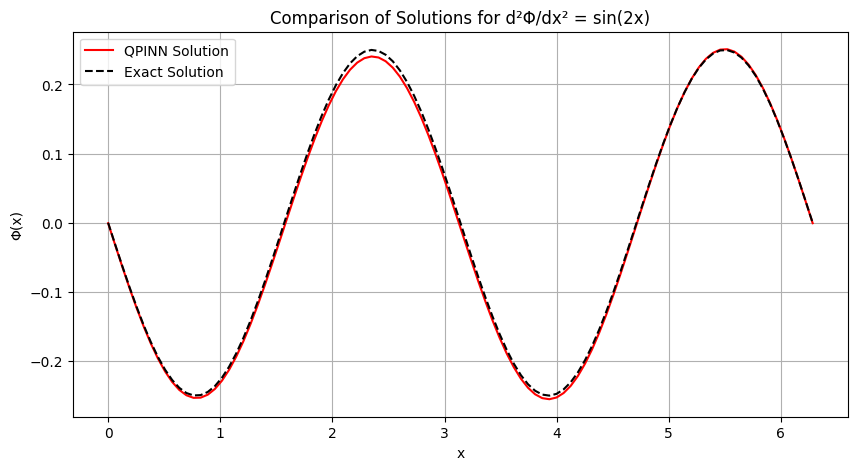

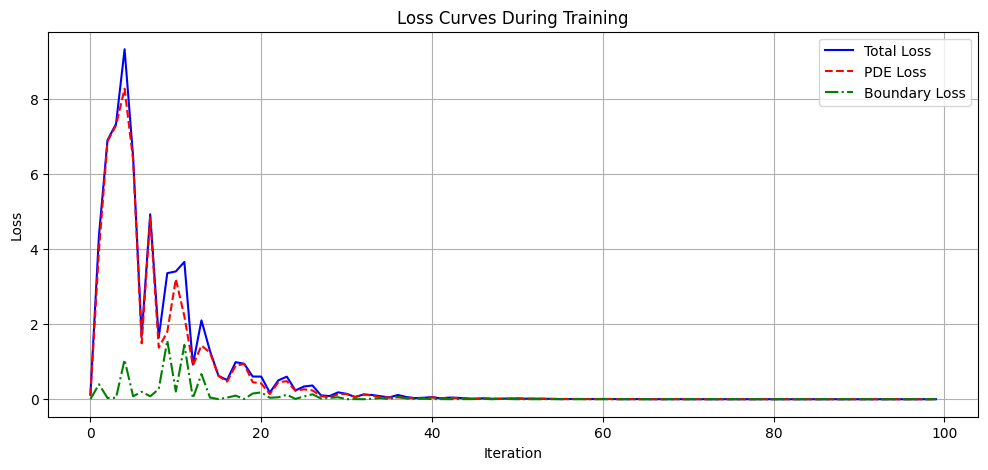

In [12]:
main_device = torch.device("cpu")
# ----------------------------------------------------------
# Construct the physics-informed loss function (PDE residual and boundary conditions)
# ----------------------------------------------------------
def compute_pde_residual(phi_pred, x):
    """
    Compute the PDE residual:
        d²Φ/dx² - sin(2x) = 0
    Use PyTorch’s automatic differentiation to compute the first and second derivatives.
    """
    # Compute the first derivative dΦ/dx
    dphi_dx = torch.autograd.grad(
        phi_pred, x, grad_outputs=torch.ones_like(phi_pred), create_graph=True
    )[0]
    # Compute the second derivative d²Φ/dx²
    d2phi_dx2 = torch.autograd.grad(
        dphi_dx, x, grad_outputs=torch.ones_like(dphi_dx), create_graph=True
    )[0]
    # Define the PDE residual as d²Φ/dx² - sin(2x)
    residual = d2phi_dx2 - torch.sin(2 * x)
    return residual

def loss_function(x):
    """
    Compute the total loss:
      - PDE loss: Mean squared error of the residual
      - Boundary condition loss: Penalty enforcing Φ(0)=0 and Φ(2π)=0
    """
    x.requires_grad_(True)
    phi_pred = model(x)
    residual = compute_pde_residual(phi_pred, x)
    pde_loss = torch.mean(residual**2)

    # Boundary conditions: Φ(0)=0 and Φ(2π)=0. Ensure these tensors are on the main device.
    bc0 = model(torch.tensor([0.0], dtype=x.dtype, device=main_device))
    bc1 = model(torch.tensor([2 * np.pi], dtype=x.dtype, device=main_device))
    bc_loss = torch.mean(bc0**2) + torch.mean(bc1**2)

    total_loss = pde_loss + bc_loss  # You can weigh the boundary loss term if needed.
    return total_loss, pde_loss, bc_loss

# ----------------------------------------------------------
# Model training
# ----------------------------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Create training data on the main device.
x_train = torch.linspace(0, 2 * np.pi, n_points, dtype=torch.float32, device=main_device)

total_loss_list = []
pde_loss_list = []
bc_loss_list = []

print("Training started...")
for i in range(num_iterations):
    optimizer.zero_grad()
    total_loss_value, pde_loss_value, bc_loss_value = loss_function(x_train)
    total_loss_value.backward()
    optimizer.step()

    total_loss_list.append(total_loss_value.item())
    pde_loss_list.append(pde_loss_value.item())
    bc_loss_list.append(bc_loss_value.item())

    if (i + 1) % 50 == 0:
        print(f"Iteration {i+1}/{num_iterations}, Total Loss: {total_loss_value.item():.6f}, " +
              f"PDE Loss: {pde_loss_value.item():.6f}, Boundary Loss: {bc_loss_value.item():.6f}")

print("Training finished.")

# ----------------------------------------------------------
# Model evaluation and comparison of solutions
# ----------------------------------------------------------
# Generate evaluation grid on the main classical device.
x_eval = torch.linspace(0, 2 * np.pi, 100, dtype=torch.float32, device=main_device)
with torch.no_grad():
    phi_pred_eval = model(x_eval)

def exact_solution(x):
    """
    Exact solution:
      Φ(x) = -1/4 * sin(2x)
    """
    return -0.25 * torch.sin(2 * x)

phi_exact_eval = exact_solution(x_eval)

# ----------------------------------------------------------
# Plot the comparison between QPINN solution and the exact solution
# ----------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(x_eval.cpu().numpy(), phi_pred_eval.cpu().numpy(), 'r-', label='QPINN Solution')
plt.plot(x_eval.cpu().numpy(), phi_exact_eval.cpu().numpy(), 'k--', label='Exact Solution')
plt.title("Comparison of Solutions for d²Φ/dx² = sin(2x)")
plt.xlabel("x")
plt.ylabel("Φ(x)")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------------------
# Plot the loss curves during training
# ----------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.plot(total_loss_list, 'b-', label='Total Loss')
plt.plot(pde_loss_list, 'r--', label='PDE Loss')
plt.plot(bc_loss_list, 'g-.', label='Boundary Loss')
plt.title("Loss Curves During Training")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
